## Westeros electrified - intoducing a HIGH C02 cap

This notebook looks at how the model reacts when a high C02 cap is introduced. In this case, high is defined as a "non strict" high bound. Meaning, the amount of emissions allowed is greater than in a low cap. We will be introducing a simple bound and looking at the activity, capacity and electricity price of the model.

By Maja Heim

In [2]:
import pandas as pd
import ixmp
import message_ix

from message_ix.util import make_df

%matplotlib inline

<IPython.core.display.Javascript object>

In [3]:
mp = ixmp.Platform()

### The Baseline Scenario:

The baseline scenario represents a simple energy model. It's fundamental purpose is to satisfy the demand for energy.  I will create a function which clones the existing baseline scenario, adds emissions and introduces a bound (variable input parameter).

In [4]:
def create_scenarios(bound):
    model = "Westeros Electrified"
    base = message_ix.Scenario(mp, model=model, scenario="baseline")
    scen = base.clone(
        model,
        "emission_bound",
        "introducing an upper bound on emissions",
        keep_solution=False,
    )
    scen.check_out()
    year_df = scen.vintage_and_active_years()
    vintage_years, act_years = year_df["year_vtg"], year_df["year_act"]
    model_horizon = scen.set("year")
    country = "Westeros"

    #Introducing Emissions:
    # First we introduce the emission of CO2 and the emission category GHG
    scen.add_set("emission", "CO2")
    scen.add_cat("emission", "GHG", "CO2")

    # Then we add new units to the model library (needed only once)
    mp.add_unit("tCO2/kWa")     #tC02...tons of carbon dioxide
    mp.add_unit("MtCO2")        #MtC02...mega tons of carbon dioxide

    # Last we add CO2 emissions to the coal powerplant
    emission_factor = make_df(
        "emission_factor",
        node_loc=country,
        year_vtg=vintage_years,
        year_act=act_years,
        mode="standard",
        unit="tCO2/kWa",
        technology="coal_ppl",
        emission="CO2",
        value=7.4,
    )
    scen.add_par("emission_factor", emission_factor)

    #Adding the bound on emissions:
    #The `"type_year": "cumulative"` assigns an upper bound on the *weighted average of emissions* over the entire time horizon.
    #The first bound being introduced is relatively high, meaning the amount of emissions being released is high.
    scen.add_par(
    "bound_emission", [country, "GHG", "all", "cumulative"], value=bound, unit="MtCO2"
    )

    #solve the model
    scen.commit(comment="Introducing emissions and setting an upper bound")
    scen.set_as_default()
    scen.solve()
    scen.var("OBJ")["lvl"]

    return scen

### Creating a reference bound
For reference sake, I will run the model with a very high bound with the goal of having similar result to the baseline scenario. This way I get a feeling what a high or low bound for the system is. We will start by running the model with a bound of 800 MtC02 of average emissions per year. Due to previously running the baseline model, I know that the result is: 173795.09375

In [5]:
#running the model with 800:
scen_high = create_scenarios(800)
scen_high.var("OBJ")["lvl"]

173795.09375

In [6]:
#Just to see if it has any effect, I will run the model with 600:
scen_high = create_scenarios(600)
scen_high.var("OBJ")["lvl"]

179473.515625

## Adding a HIGH Bound on Emissions

As we can see from above, when adding a bound of 600, the model solution starts to change, meaning the bound has reached a level where an effect can be measured. We will therefore start with a bound of 600 MtCO2.

In [7]:
from message_ix.reporting import Reporter
from message_ix.util.tutorial import prepare_plots


### Activity
--> The amount of energy that is generated in each time period from the different potential sources.

We will start by looking at the energy system activity of the baseline scenario:


#### Baseline Scenario:

<Axes: title={'center': 'Westeros Energy System Activity'}, xlabel='Year', ylabel='GWa'>

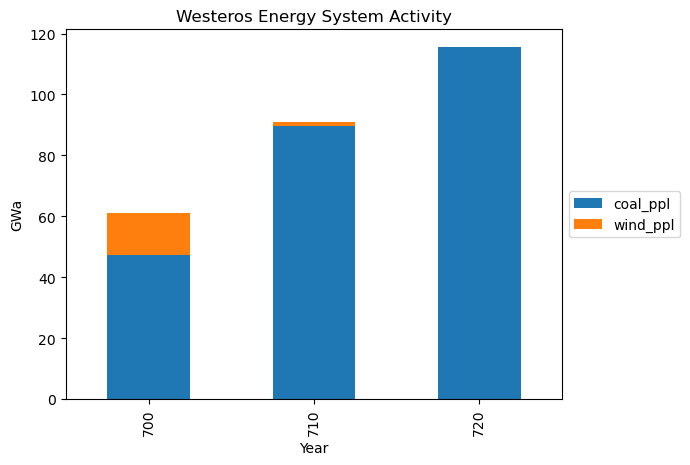

In [8]:
scen_base = create_scenarios(800)       #a bound of 800 doesn't influence the system (as shown above)
rep = Reporter.from_scenario(scen_base)
prepare_plots(rep)
rep.set_filters(t=["coal_ppl", "wind_ppl"])
rep.get("plot activity")

##### increase of wind power plant activity
Due to the fact that we have set a very high bound (low ambition) the amount of coal power plants being used is still very high, but we can see wind power plants being introduced. Compared to the baseline scenario, the wind power plant activity is the same in the year 700, but changes in the following years. This is because the bound is reached and alternative energy sources have to be introduced.


#### High Bound Scenario:

<Axes: title={'center': 'Westeros Energy System Activity'}, xlabel='Year', ylabel='GWa'>

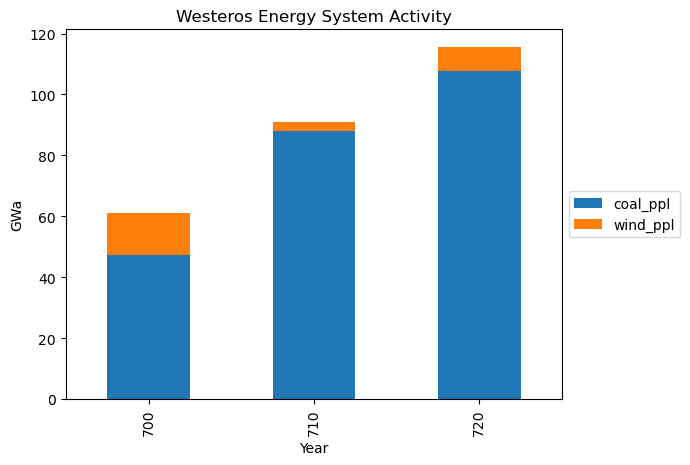

In [9]:
scen_high = create_scenarios(600)
rep = Reporter.from_scenario(scen_high)
prepare_plots(rep)
rep.set_filters(t=["coal_ppl", "wind_ppl"])
rep.get("plot activity")

### Capacity
--> The amount of capacity of each plant that is installed

The two diagrams below compare the baseline scenario, to the high bound scenario. As the bound is introduced, the activity of the wind power plant increases. Similar to the activity from before, the capacity in the beginning of both scenarios is the same, but the introduction of the wind power plant increases as the years go on. This is because the bound is being reached the closer the time inches towards the end of the model horizon.

#### Baseline Scenario:

<Axes: title={'center': 'Westeros Energy System Capacity'}, xlabel='Year', ylabel='GW'>

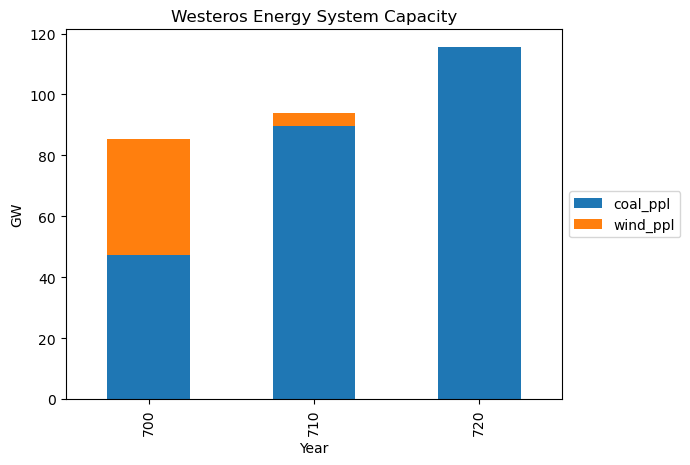

In [10]:
scen_base = create_scenarios(800)       #a bound of 800 doesn't influence the system (as shown above)
rep = Reporter.from_scenario(scen_base)
prepare_plots(rep)
rep.set_filters(t=["coal_ppl", "wind_ppl"])
rep.get("plot capacity")

<Axes: title={'center': 'Westeros Energy System Capacity'}, xlabel='Year', ylabel='GW'>

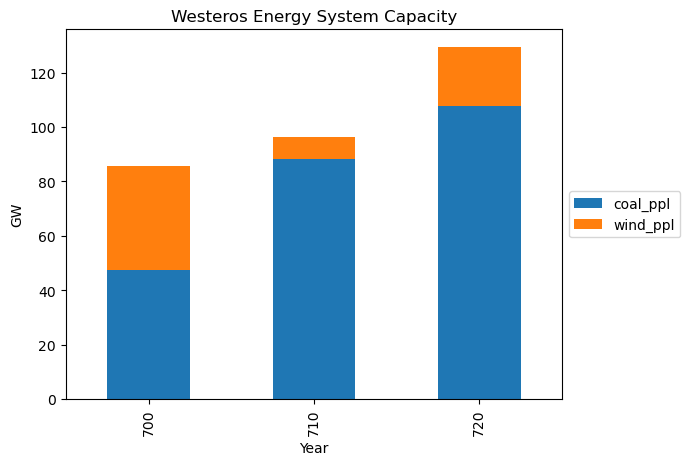

In [11]:
scen_high = create_scenarios(600)
rep = Reporter.from_scenario(scen_high)
prepare_plots(rep)
rep.set_filters(t=["coal_ppl", "wind_ppl"])
rep.get("plot capacity")

#### High Bound Scenario:

### Electricity Price
--> The price of electricity

#### Baseline scenario:

<Axes: title={'center': 'Westeros Energy System Prices'}, xlabel='Year', ylabel='¢/kW·h'>

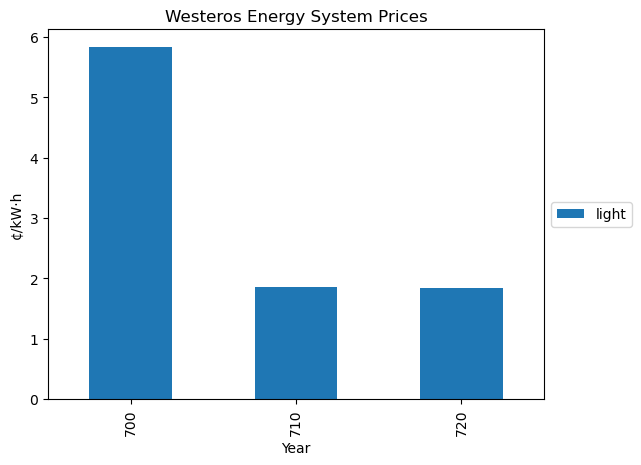

In [12]:
scen_base = create_scenarios(800)       #a bound of 800 doesn't influence the system (as shown above)
rep = Reporter.from_scenario(scen_base)
prepare_plots(rep)
rep.set_filters(t=None, c=["light"])
rep.get("plot prices")

Around 700, the electricity price in the baseline scenario is more expensive. This is because the capacity and activity of wind and coal is almost 50% around that time. In the years after, the price drops significantly in the baseline scenario, because it is no longer being invested in wind power plants. The energy mix therefore is dominated by coal and the electricity price becomes cheaper.

The high bound scenario's price drops around 710 because, just like in the baseline scenario, the investment in wind is decreasing because of the high electricity price resulting from it. As the scenario reaches it's end around 720, with the bound limit also being reached, wind power plants are being introduced again. Therefore, the price increases.
#### High Bound Scenario:

<Axes: title={'center': 'Westeros Energy System Prices'}, xlabel='Year', ylabel='¢/kW·h'>

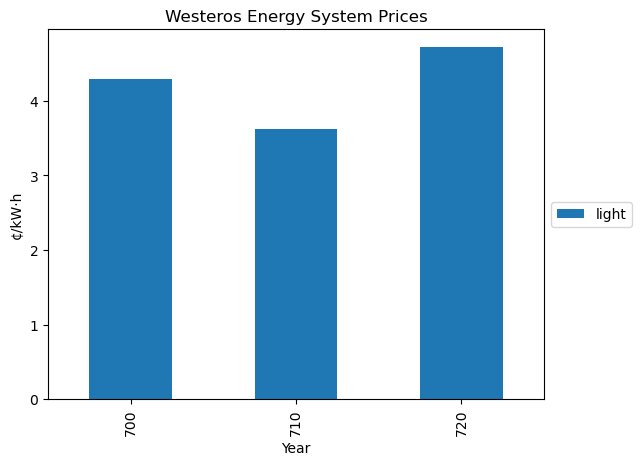

In [13]:
scen_high = create_scenarios(600)
rep = Reporter.from_scenario(scen_high)
prepare_plots(rep)
rep.set_filters(t=None, c=["light"])
rep.get("plot prices")

## Close the connection to the database

In [14]:
mp.close_db()